- credit이 0에 가까울 수록 좋은 것
- 해당자가 그 행에 대응되는 신용카드를 발급받은 이후 데이터 수집일까지의 대금 연체 정도

In [14]:
!pip install --upgrade pandas==1.2

  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


pyldavis 3.3.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
phik 0.12.0 has requirement scipy>=1.5.2, but you'll have scipy 1.2.1 which is incompatible.
pandas-profiling 3.1.0 has requirement joblib~=1.0.1, but you'll have joblib 0.17.0 which is incompatible.
pandas-profiling 3.1.0 has requirement matplotlib>=3.2.0, but you'll have matplotlib 3.0.3 which is incompatible.
pandas-profiling 3.1.0 has requirement scipy>=1.4.1, but you'll have scipy 1.2.1 which is incompatible.
pandas-profiling 3.1.0 has requirement seaborn>=0.10.1, but you'll have seaborn 0.9.0 which is incompatible.
Could not install packages due to an EnvironmentError: [WinError 5] 액세스가 거부되었습니다: 'c:\\anaconda3\\lib\\site-packages\\~andas\\io\\msgpack\\_packer.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [115]:
train = pd.read_csv('credit_card_data/open/train.csv')
#train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_credit_cart/credit_card_data/open/train.csv')


test = pd.read_csv('credit_card_data/open/test.csv')
submit =  pd.read_csv('credit_card_data/open/sample_submission.csv')


train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [52]:
train.shape

(26457, 20)

In [53]:
len(train.index.unique())

26457

# 1. Feature 이해 및 EDA

ⓐ reality: 부동산 소유 여부

ⓑ house_type: 생활 방식

ⓒ DAYS_BIRTH: 출생일 / 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

ⓓ DAYS_EMPLOYED: 업무 시작일 / 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 / 양수 값은 고용되지 않은 상태를 의미함

ⓔ FLAG_MOBIL: 핸드폰 소유 여부

ⓕ work_phone: 업무용 전화 소유 여부

ⓖ begin_month: 신용카드 발급 월

### 1) 결측치 확인
occyp_type 직업 유형에서 null 값이 있는 것을 확인

In [32]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

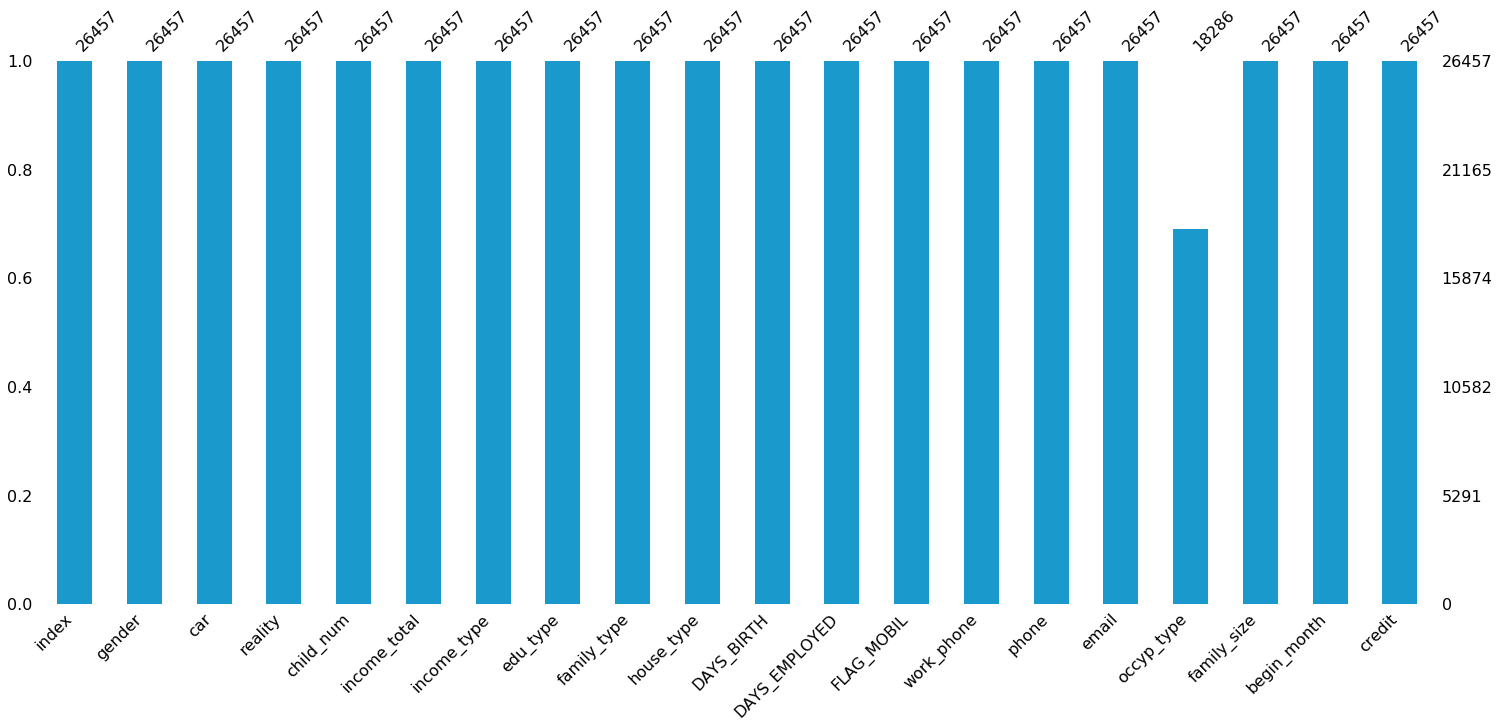

In [6]:
import missingno as msno
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

- 데이터 형 변환

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [7]:
# credit 형 변환
train = train.astype({'credit': 'object'})
print(train.dtypes)

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit            object
dtype: object


### 2) Categorical Variable EDA

In [19]:
# 범주형 데이터 확인

train.income_type.unique(), train.edu_type.unique(), train.family_type.unique(), train.house_type.unique()

(array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
        'Student'], dtype=object),
 array(['Higher education', 'Secondary / secondary special',
        'Incomplete higher', 'Lower secondary', 'Academic degree'],
       dtype=object),
 array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Municipal apartment', 'House / apartment', 'With parents',
        'Co-op apartment', 'Rented apartment', 'Office apartment'],
       dtype=object))

#### credit: 신용 등급 비율
- 낮을수록 높은 신용의 신용카드 사용자를 의미 
- 낮은 신용의 신용카드 사용자가 많다는 것을 알 수 있다.

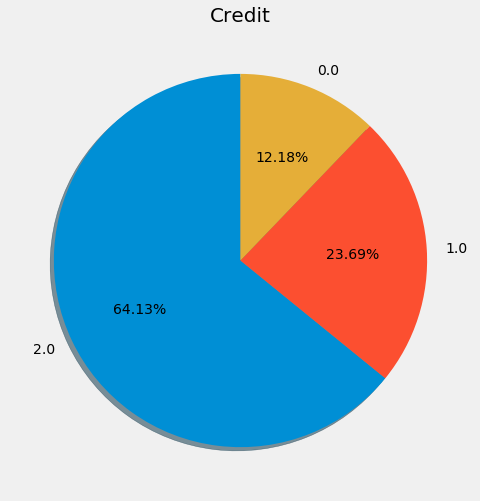

In [16]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Credit', size=20)
plt.show()

In [17]:
# 등급에 따른 차이를 보기 위해 데이터 분류
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]


# Categorical 그래프 함수 정의
def cat_plot(column):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

#### gender

- 남녀 비율 차이가 2배가 나타남

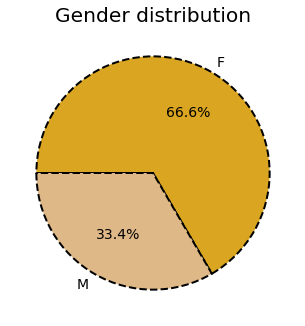

In [94]:
df1= train.groupby('gender').count()['index']
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(df1, labels=df1.index,colors=['goldenrod','burlywood'], startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Gender distribution')
plt.show()

신용등급에 따라 성별 차이가 존재하는지 확인
- 모든 등급에서 남성보다 여성이 더 많음

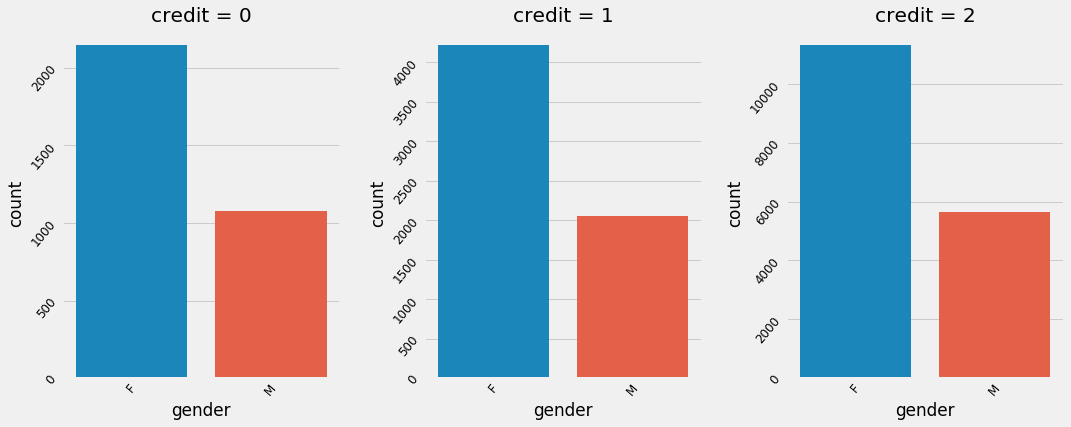

In [18]:
cat_plot("gender")

#### car

- 차를 소유하지 않은 사람이 2배 더 많음

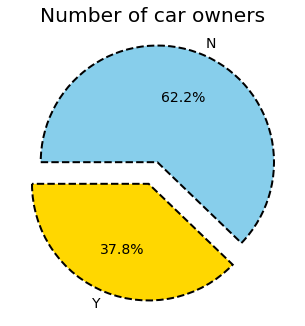

In [105]:
df1= train.groupby('car').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(df1, labels=df1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()


신용등급에 따라 차량 소유 차이가 존재하는지 확인
- 모든 등급에서 차를 보유하고 있지 않은 사람이 매우 많음

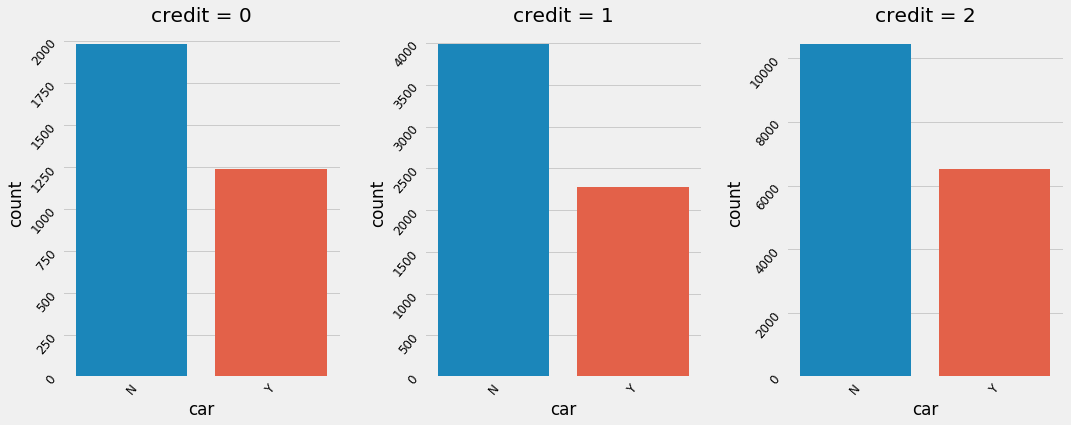

In [19]:
cat_plot('car')

#### reality
신용등급에 따라 부동산 소유 차이가 존재하는지 확인
- 모든 등급에서 부동산을 소유한 사람들이 많음
- 등급에 따른 차이가 존재하지 않는다.

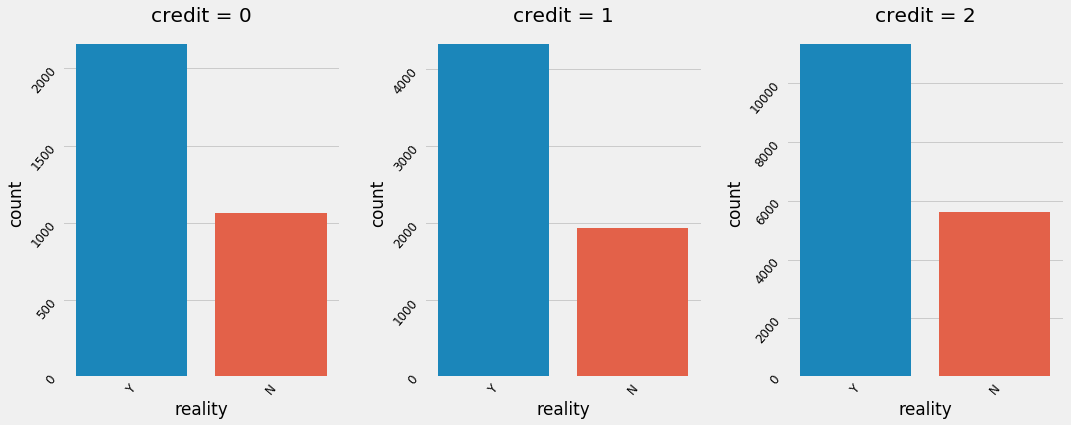

In [20]:
cat_plot('reality')

#### income_type
신용등급에 따라 소득 분류 차이가 존재하는지 확인
- 높은 신용에서는 학생이 존재하지 않음

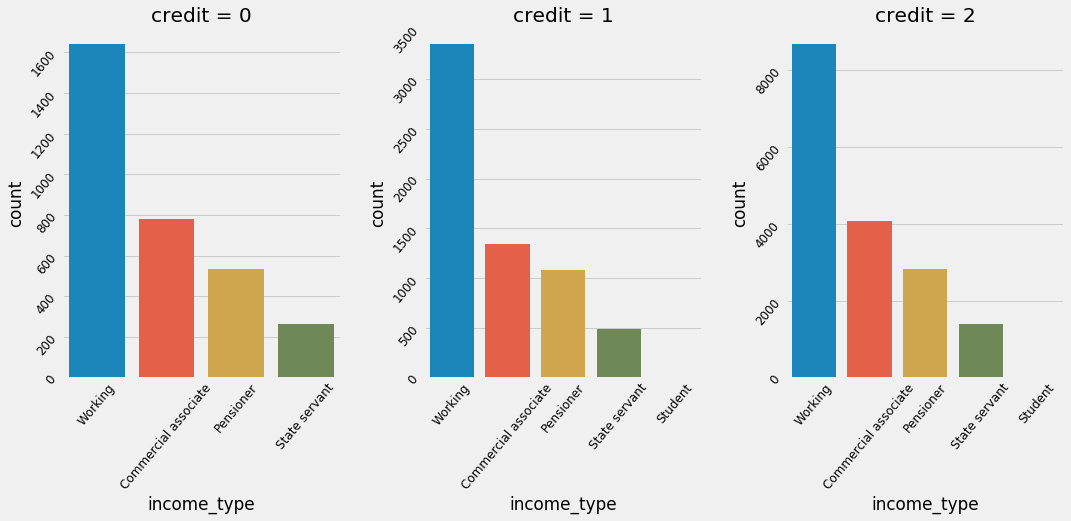

In [21]:
cat_plot('income_type') 

#### edu_type
신용등급에 따라 교육 수준 차이가 존재하는지 확인
- 모든 등급에서 모든 등급에서 교육 수준의 순위가 같음

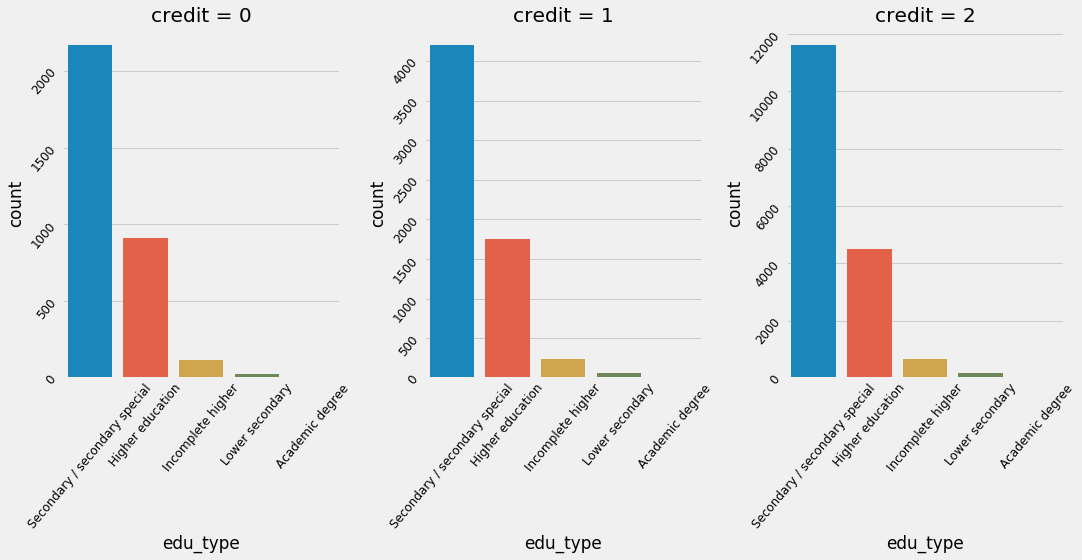

In [22]:
cat_plot('edu_type')

#### family_type
신용등급에 따라 결혼 여부 차이가 존재하는지 확인
- 모든 등급에서 결혼을 한 사람들이 매우 많음

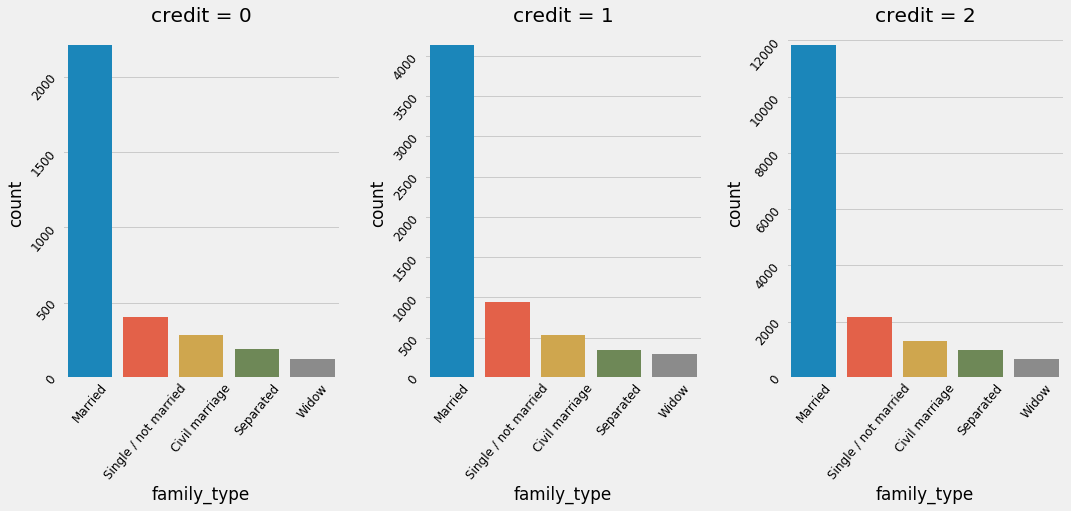

In [23]:
cat_plot('family_type')

#### house_type
신용등급에 따라 생활방식 차이가 존재하는지 확인
- 모든 등급에서 교육 수준의 순위가 같음

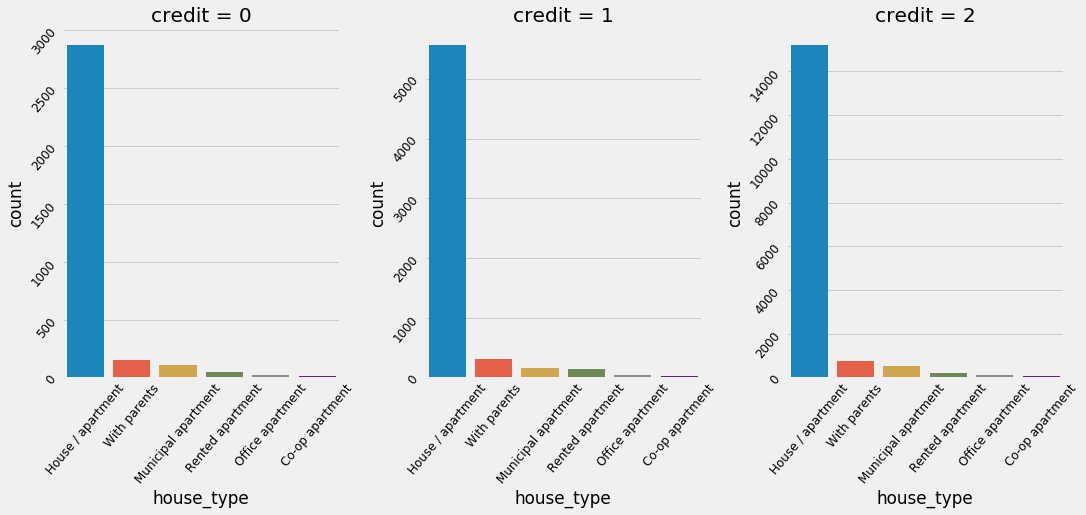

In [24]:
cat_plot('house_type')

#### FLAG_MOBIL
신용등급에 따라 휴대폰 소지 차이가 존재하는지 확인
- 모든 사람들이 휴대폰을 소지함
- 해당 컬럼 삭제하기

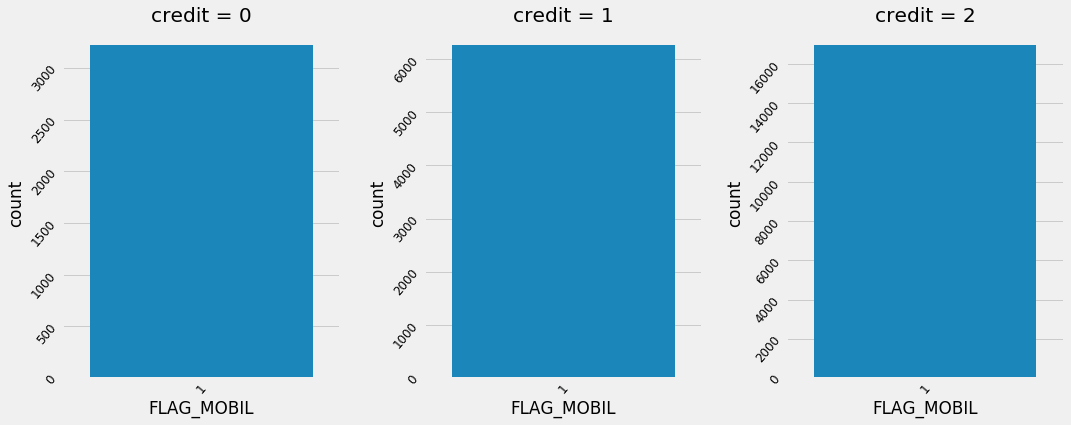

In [25]:
cat_plot('FLAG_MOBIL')

#### work_phone
신용등급에 따라 업무용 전화 소유 차이가 존재하는지 확인

- 모든 등급에서 업무용 전화를 소유하고 있지 않는 사람들이 많음
- 예측에 중요한 feature는 아니라고 판단

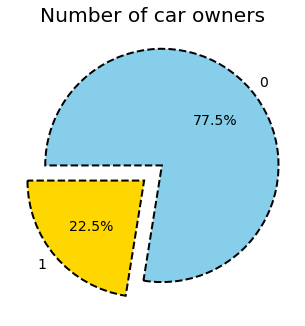

In [138]:
df1= train.groupby('work_phone').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(df1, labels=df1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()

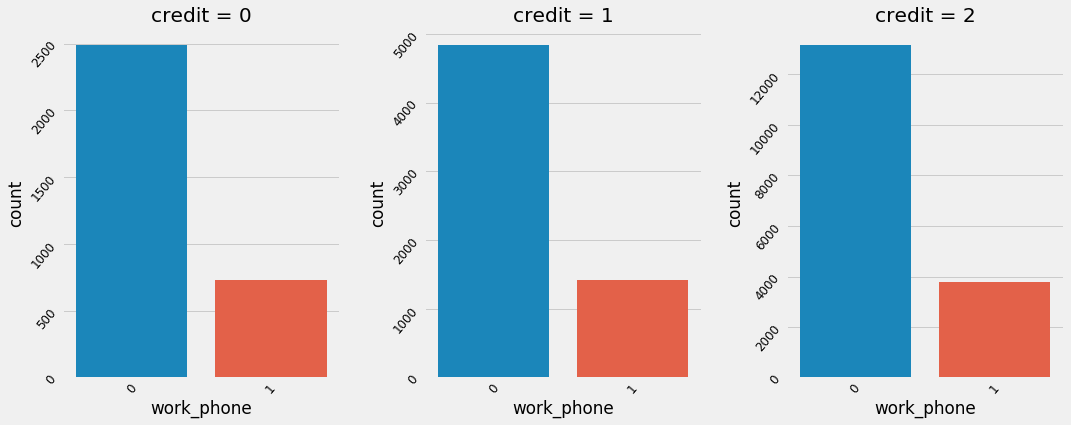

In [26]:
cat_plot('work_phone')

#### phone
신용등급에 따라 가정용 전화 소유 차이가 존재하는지 확인

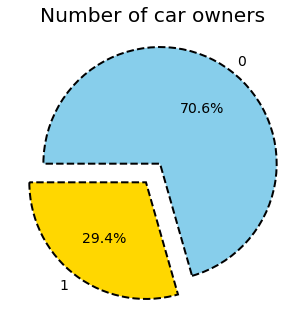

In [130]:
df1= train.groupby('phone').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(df1, labels=df1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()

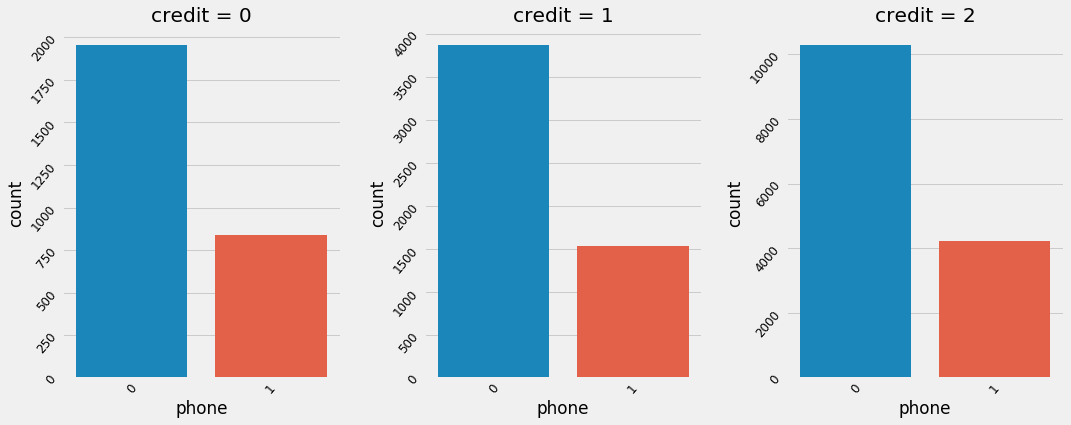

In [135]:
cat_plot('phone')

#### email
신용등급에 따라 이메일 소유 차이가 존재하는지 확인
- 모든 등급에서 이메일을 소유한 사람들이 훨씬 많음

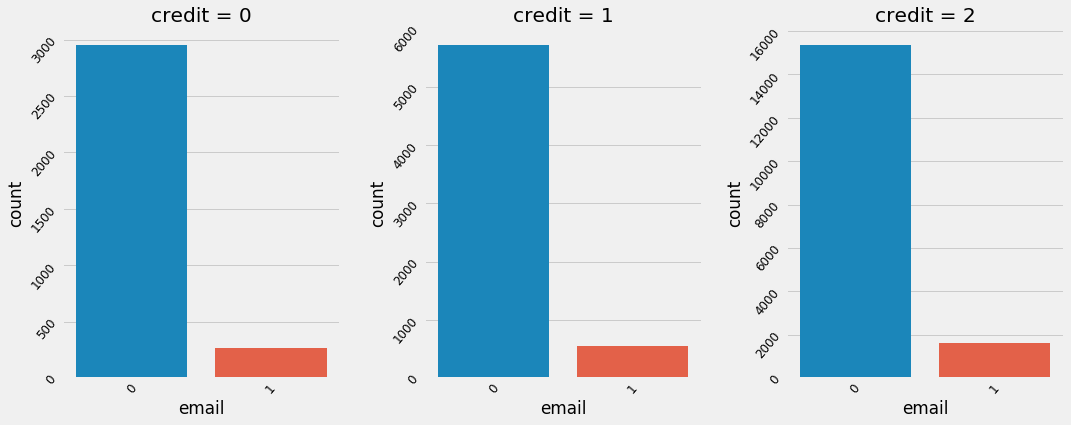

In [27]:
cat_plot('email')

### occyp_type

1) 해당 변수의 결측치 처리 후, EDA 수행
- 해당 변수는 결측치가 존재했음. 
- DAYS_EMPLOYED 가 양수인 경우, 무직이므로 No job으로 대체
- 이외 값은 제거하고 EDA 확인

In [140]:
# 결측치
print(len(train[train['occyp_type'].isnull()]))

# 결측치 중 무직인 경우
print(len(train[train.DAYS_EMPLOYED >=0]))

8171
4438


In [59]:
# 결측치 제거
# occyp_type이 nan이면서 취직을 한 경우
nan_index = train[(train['DAYS_EMPLOYED'] < 0) & (train['occyp_type'].isnull()) ].index
train = train.drop(nan_index)

# 무직인 경우 NO job으로 대체
# occyp_type이 nan이면서 취직을 하지 않은 경우
train = train.fillna({'occyp_type':'No job'})  # 4438 row
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0


In [60]:
train[train.occyp_type == 'No job']

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,No job,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,No job,2.0,-37.0,2.0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,No job,2.0,-7.0,2.0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,1,0,1,0,No job,1.0,-5.0,2.0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,1,0,1,0,No job,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,1,0,0,1,No job,1.0,-60.0,1.0
26432,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,1,0,1,0,No job,2.0,-17.0,1.0
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,No job,2.0,-57.0,2.0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,1,0,0,0,No job,1.0,-43.0,2.0


2) 신용등급에 따라 직업 유형 차이가 존재하는지 확인
- 등급별로 직업 유형의 순위 변동이 조금 존재

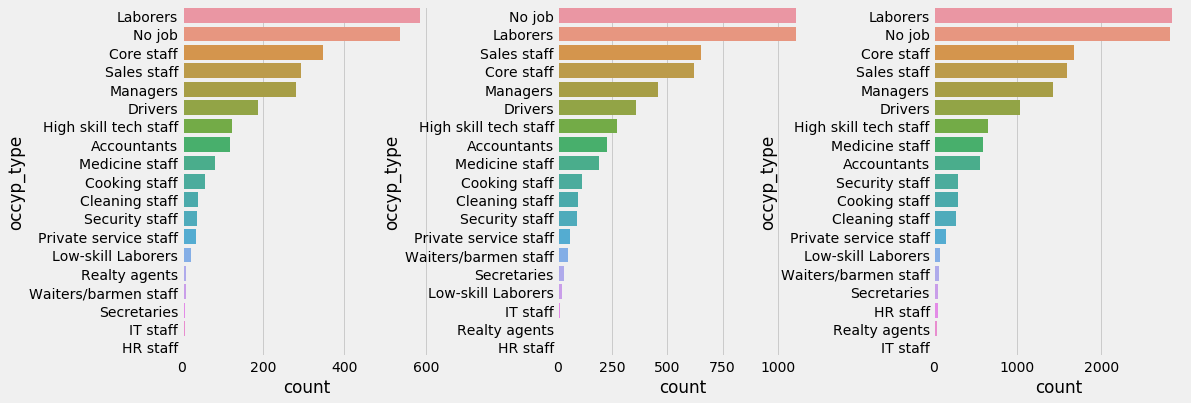

In [61]:
train_0 = train[train.credit == 0]
train_1 = train[train.credit == 1]
train_2 = train[train.credit == 2]


f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

## 3) Numerical Variable EDA

In [38]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [119]:
# Numerical 그래프 함수 정의
def num_plot(column):
    
# 등급에 따른 차이를 보기 위해 데이터 분류
    train_0 = train[train['credit']==0.0]
    train_1 = train[train['credit']==1.0]
    train_2 = train[train['credit']==2.0]


    fig, axes = plt.subplots(1, 3, figsize=(16, 6))


    sns.distplot(train_0[column],
                ax = axes[0])
    axes[0].tick_params(labelsize=12)
    axes[0].set_title('credit = 0')
    axes[0].set_ylabel('count')

    sns.distplot(train_1[column],
                ax = axes[1])
    axes[1].tick_params(labelsize=12)
    axes[1].set_title('credit = 1')
    axes[1].set_ylabel('count')

    sns.distplot(train_2[column],
                ax = axes[2])
    axes[2].tick_params(labelsize=12)
    axes[2].set_title('credit = 2')
    axes[2].set_ylabel('count')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

#### child_num
신용등급에 따라 자녀수 차이가 존재하는지 확인
- 등급별 차이가 거의 없음

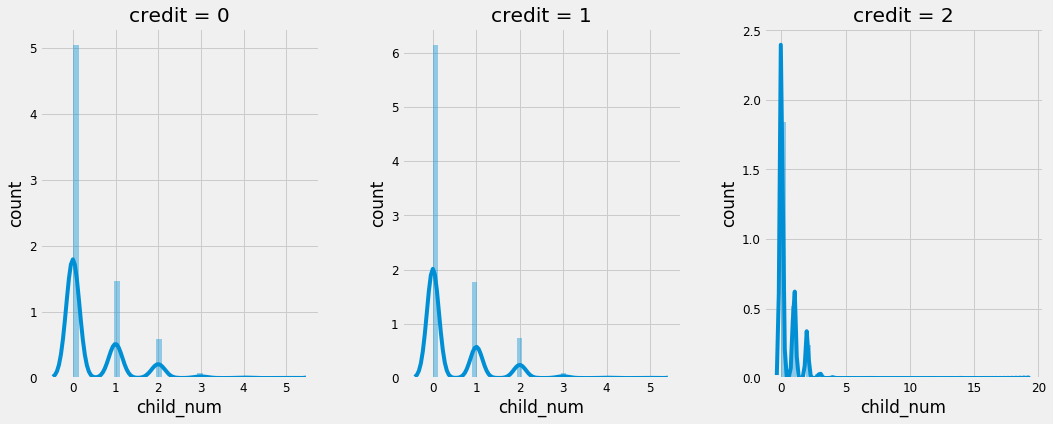

In [97]:
num_plot("child_num")

#### income_total
신용등급에 따라 연간 소득 차이가 존재하는지 확인
- 등급별 차이가 거의 없음

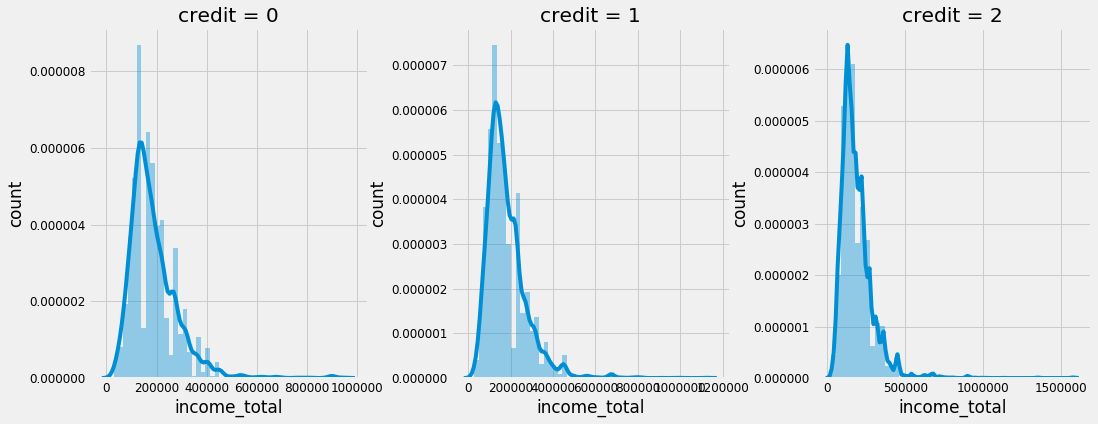

In [80]:
num_plot("income_total")

#### DAYS_BIRTH, Age
Age 변수 생성 후, 분포 확인

- 30, 40, 50대가 주를 이루고 있음

In [98]:
train['Age'] = abs(train['DAYS_BIRTH'])/360

train = train.astype({'Age': 'int'})
train['Age'].head()

1    31
2    53
3    41
4    41
5    37
Name: Age, dtype: int32

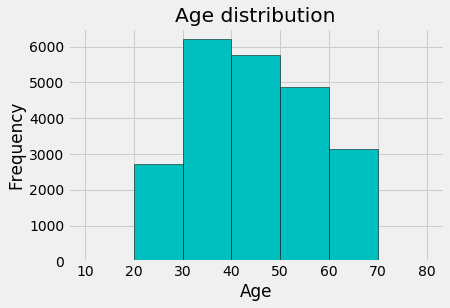

In [99]:
train['Age'].plot.hist(bins=range(10,81,10),color='c', edgecolor='k')
plt.xlabel('Age')
plt.title('Age distribution')
plt.show()

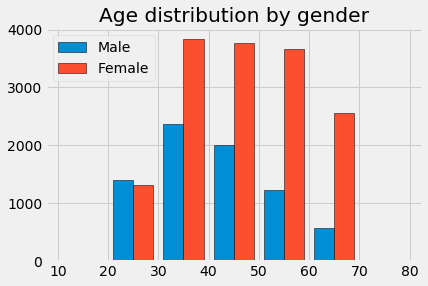

In [104]:
# 성별에 따른 분포
sex = train.groupby('gender')
M_group= sex.get_group('M')
F_group= sex.get_group('F')
M = M_group['Age']
F = F_group['Age']

plt.hist([M,F], bins=range(10,81,10), label=['Male', 'Female'],edgecolor='k')
plt.legend(loc='upper left')
plt.title('Age distribution by gender')
plt.show()

신용등급에 따라 연령대 차이가 존재하는지 확인
- 등급별 차이가 거의 없음. 모든 등급에서 20~30대 비율이 낮음

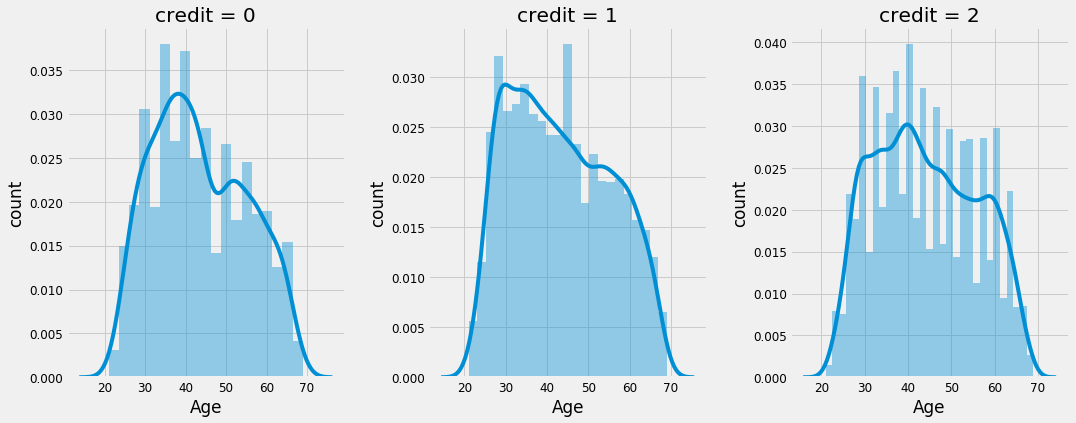

In [122]:
train['Age'] = abs(train['DAYS_BIRTH'])/360
train = train.astype({'Age': 'int'})

num_plot("Age")

#### DAYS_EMPLOYED, days_employed
- employed 변수 생성 후, 신용등급에 따라 업무 기간 차이가 존재하는지 확인
- 양수는 무직을 의미하므로 0으로 대체


- 대체적으로 직업이 없는 사람들이 많음
- 등급별 차이가 거의 없음

In [125]:
train['days_employed']= train['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train['days_employed'] = abs(train['days_employed'])/360
train = train.astype({'days_employed': 'int'})

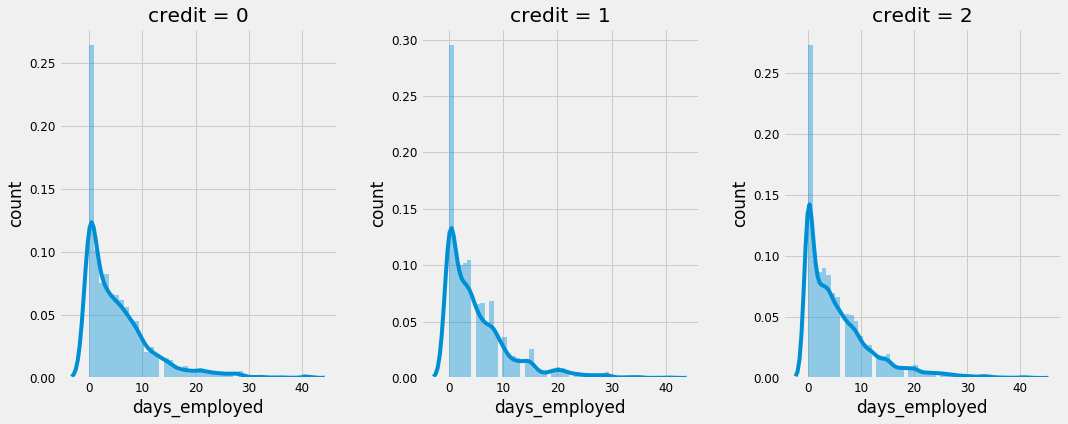

In [126]:
num_plot("days_employed")

#### family_size
신용등급에 따라 가족 수 차이가 존재하는지 확인

- 보통 가족 수가 2명인 사람들이 많음
- 결혼한 사람들이 많았던 결과와 연관되는 결과
- 2등급에서는 1,2에 비해 왼쪽으로 치우진 그래프가 나옴

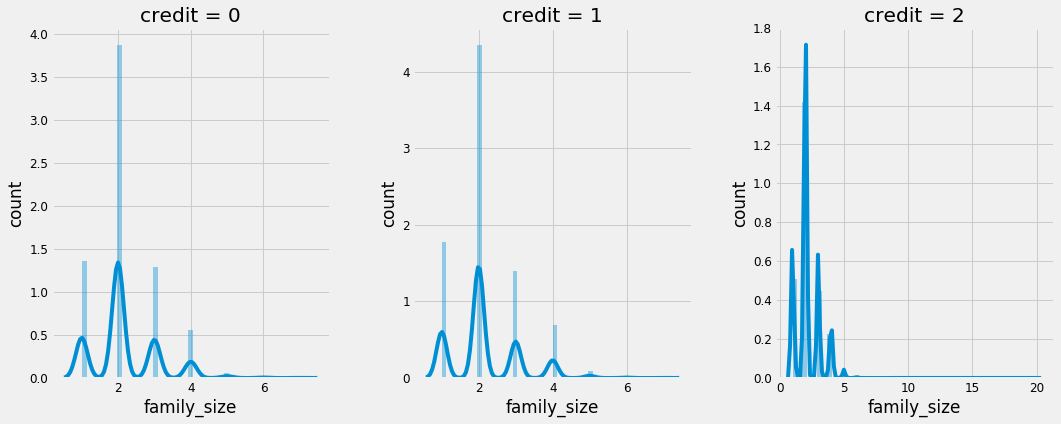

In [89]:
num_plot("family_size")

#### begin_month, Month
Month 변수 생성 후, 신용등급에 따라 카드 발급 기간 차이가 존재하는지 확인
- 대부분 카드를 발급 받은지 10달 이하인 사람들이 많음

In [127]:
train['Month'] = abs(train['begin_month'])
train = train.astype({'Month': 'int'})
train['Month'].head()

0     6
1     5
2    22
3    37
4    26
Name: Month, dtype: int32

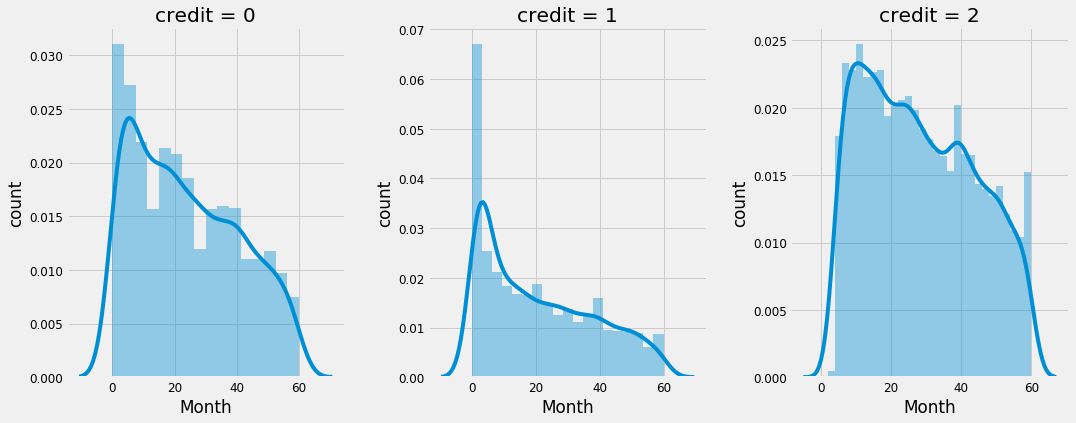

In [141]:
num_plot("Month")

# 2. 데이터 전처리

#### 1. 중복 값 확인 및 제거

In [28]:
train.shape, len(train.index.unique())

((26457, 20), 26457)

In [70]:
train[train.duplicated()]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age


begin_month와 month와 다른 값을 가지고, 모든 컬럼의 값이 같다면 중복 값이라고 볼 수 있음
이를 어떻게 처리할 것인가. 어떤 값을 남길 것인가

#### 2. NULL 값 확인 및 처리

In [24]:
train.isnull().sum()  #  occyp_type 직업 유형에서 null 값이 있는 것을 확인

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [25]:
train.occyp_type.unique()

array([nan, 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

#### 3. 이상치 처리

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [147]:
train.family_size.unique()

array([ 2.,  3.,  4.,  1.,  5.,  6.,  7., 15., 20.,  9.])

In [169]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [171]:
train[train.family_size==7]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,days_employed,Age,Month
2671,2671,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,7.0,-11.0,2.0,9,36,11
9615,9615,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,...,0,0,0,Managers,7.0,-19.0,1.0,7,31,19
10321,10321,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,...,0,0,0,Managers,7.0,-46.0,0.0,7,31,46
12876,12876,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,7.0,-15.0,1.0,9,36,15
17560,17560,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,7.0,-20.0,1.0,9,36,20
17978,17978,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,...,0,0,0,Managers,7.0,-21.0,1.0,7,31,21
19792,19792,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,...,0,0,0,Managers,7.0,-59.0,0.0,7,31,59
20117,20117,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,7.0,-21.0,1.0,9,36,21
22592,22592,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,7.0,-10.0,1.0,9,36,10


In [148]:
train[train.family_size==15]
# 3명이 동일한 인물

해당 인물이 다른 컬럼에 존재하는지 확인 9에 존재하는 거 같음

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,days_employed,Age,Month
8462,8462,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,...,0,0,0,Drivers,15.0,-7.0,2.0,4,49,7
9021,9021,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,...,0,0,0,Drivers,15.0,-58.0,2.0,4,49,58
25390,25390,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,...,0,0,0,Drivers,15.0,-43.0,2.0,4,49,43


In [170]:
train[train.family_size==9]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,days_employed,Age,Month
25313,25313,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,1,0,Cleaning staff,9.0,-26.0,2.0,4,38,26
25638,25638,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,1,0,Cleaning staff,9.0,-31.0,2.0,4,38,31


In [149]:
train[train.family_size==20]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,days_employed,Age,Month
10731,10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,1,1,0,Waiters/barmen staff,20.0,-5.0,2.0,5,30,5


- begin_month와 month와 다른 값을 가지고, 모든 컬럼의 값이 같다면 중복 값이라고 볼 수 있음
- 이를 어떻게 처리할 것인가. 어떤 값을 남길 것인가

# 3. Feature engineering


- FLAG_MOBIL 컬럼 삭제
모든 사람들이 휴대폰을 소지함. 의미있는 feature가 아니라고 판단

In [64]:
# DAYS_BIRTH와 begin_month를 양수 값으로 변경

#train[train.DAYS_BIRTH>0]   
#train[train.begin_month>0]  

train['DAYS_BIRTH'] = train.DAYS_BIRTH.apply(lambda x: abs(x))
test['DAYS_BIRTH'] = test.DAYS_BIRTH.apply(lambda x: abs(x))


train['begin_month'] = train.DAYS_BIRTH.apply(lambda x: abs(x))
test['begin_month'] = test.DAYS_BIRTH.apply(lambda x: abs(x))

- age 컬럼 생성

In [68]:
# DAYS_BIRTH는 출생일을 의미. 해당 값을 나이로 변환

train['age'] = round(train.DAYS_BIRTH/365)

train = train.drop(['DAYS_BIRTH'], axis=1)
train['age'].describe()

count    26457.000000
mean        43.731186
std         11.521771
min         21.000000
25%         34.000000
50%         43.000000
75%         53.000000
max         69.000000
Name: age, dtype: float64

#### 3.Creating Feature

- DAYS_EMPLOYED
: 업무 시작일 / 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 / 양수 값은 고용되지 않은 상태를 의미함

    - 고용 여부에 따른 신용점수 차이
    - 고용 일수에 따른 신용점수 차이 
    - -> feature 생성

In [128]:
len(train[train['DAYS_EMPLOYED']>0])

4438

In [132]:
# 고용상태면 employed=1
# DAYS_EMPLOYED가 음수면 employed=1

train['employed'] = np.where(train['DAYS_EMPLOYED']<0, 1, 0)
len(train[train['employed'] == 0])

4438

4438

- begin_month: 신용카드 발급 월
    - 신용카드 발급 월에 따른 신용점수 차이

# 4. 모델링

In [ ]:
train = train.drop(['index','occyp_type'], axis=1)
train.shape

In [ ]:
x_train = train.drop(['credit'], axis =1)
y_train = train['credit']
x_train.head(3)

## 1) pycaret


In [ ]:
!pip install pycaret

     |████████████████████████████████| 266 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 12.1 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 167 kB 74.3 MB/s 
     |████████████████████████████████| 2.0 MB 73.6 MB/s 
     |████████████████████████████████| 16.9 MB 44 kB/s 
     |████████████████████████████████| 1.7 MB 91.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 111 kB 75.0 MB/s 
     |████████████████████████████████| 1.3 MB 77.7 MB/s 
     |████████████████████████████████| 271 kB 76.4 MB/s 
     |████████████████████████████████| 6.8 MB 49.0 MB/s 
     |████████████████████████████████| 261 kB 62.7 MB/s 
     |████████████████████████████████| 3.1 MB 73.0 MB/s 
     |████████████████████████████████| 596 kB 79.0 MB/s 
     |██████████████████

In [5]:
from pycaret.classification import *
from sklearn.metrics import log_loss

C:\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [8]:
clf = setup(data=train, target='credit', train_size=0.85)

,Description,Value
0,session_id,1090
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 18)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x000001C69DF86B70>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [10]:
# 데이터에 적합한 모델 찾기

#svm, ridge는 predict_proba 미지원으로 제외
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6953,0.6976,0.4244,0.6895,0.6179,0.2341,0.3177,0.7732,2.036
gbc,Gradient Boosting Classifier,0.6899,0.6538,0.409,0.6537,0.6037,0.2086,0.3014,0.7989,10.32
lda,Linear Discriminant Analysis,0.6395,0.6086,0.3358,0.5278,0.5032,0.0076,0.0384,0.8651,0.266
nb,Naive Bayes,0.6407,0.6067,0.3357,0.5466,0.5025,0.008,0.0496,0.867,0.166
lr,Logistic Regression,0.639,0.5863,0.3333,0.4083,0.4982,0,0,0.8735,8.298
rf,Random Forest Classifier,0.6946,0.7412,0.5269,0.6707,0.6753,0.3555,0.3636,0.9859,3.3
ada,Ada Boost Classifier,0.6885,0.627,0.4039,0.6269,0.5985,0.1978,0.299,1.081,1.186
et,Extra Trees Classifier,0.6682,0.7039,0.5137,0.6464,0.6529,0.3126,0.3172,2.639,4.294
knn,K Neighbors Classifier,0.6119,0.6531,0.4555,0.5871,0.596,0.2009,0.2036,4.017,1.488
dt,Decision Tree Classifier,0.6009,0.6346,0.4859,0.6114,0.6058,0.2489,0.2492,13.36,0.422


In [15]:
blended = blend_models(estimator_list = best5, fold = 5, optimize = 'logloss')
pred_holdout = predict_model(blended)

IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:42:18
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Voting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss


BrokenProcessPool: A result has failed to un-serialize. Please ensure that the objects returned by the function are always picklable.

In [ ]:
#lda 와 nb는 losloss가 좋지만 accuracy, auc가 상대적으로 좋지 않아 커스텀모델 생성
custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 6, include=['lightgbm','gbc','rf','ada', 'lda', 'nb'])

In [ ]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)

In [ ]:
#자동으로 상위 5개 선택한 모델
final_model = finalize_model(blended)

#Accurary, AUC, Logloss 셋다 상위 4개인 모델 
final_model_custom = finalize_model(blended_custom)


#Accurary, AUC, Logloss 셋다 상위 4개인 모델 사용
prep_pipe = get_config("prep_pipe")
prep_pipe.steps.append(['trained_model', final_model_custom])
prections = prep_pipe.predict_proba(test)
prections

In [ ]:
i, j, k = [], [], []
for row in prections:
  i.append(row[0])
  j.append(row[1])
  k.append(row[2])

len(i), len(j), len(k)

In [ ]:
submit['0'] = i
submit['1'] = j
submit['2'] = k
submit.head(10)

In [ ]:
submit.to_csv("\submisison.csv",index=False)

In [ ]:
total_models = []
models()

## 2) 최종 모델 학습

## 3) 최종 예측